In [4]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

import os
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.path.dirname('__file__'), "./src/"))
from utilFunctions import smooth_obs
from audio_preprocessing import getMFCCBands2DMadmom
from experiment_process_helper import boundary_decoding
from madmom.features.onsets import OnsetPeakPickingProcessor

Using TensorFlow backend.


In [5]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [3]:
import pickle

with open("training_data/scaler.pkl", "rb") as file:
    scaler = pickle.load(file)

In [6]:
my_model = load_model(os.path.join("model_output/" + 'model.h5'), custom_objects={ 'auc': auc})

In [7]:
wav_jingju = 'wavs/mayu.wav'
log_mel = scaler.transform(getMFCCBands2DMadmom(wav_jingju, 44100, 0.01, channel=1))

In [9]:
log_mel = log_mel.reshape(log_mel.shape[0], 80, 15)
log_mel = np.expand_dims(log_mel, axis=1)
pdf=my_model.predict(log_mel, batch_size = 256)
pdf = np.squeeze(pdf)
pdf = smooth_obs(pdf)

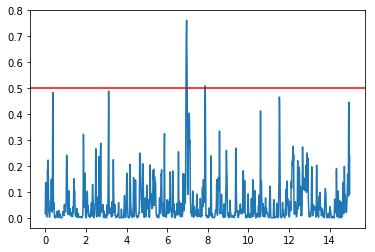

In [10]:
snip = pdf[0: 15*100]
x = np.arange(0, len(snip)) * 0.01
plt.plot(x, snip)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.show()

In [16]:
b_baseline, _ = boundary_decoding(decoding_method="lmao",
                                      obs_i=pdf,
                                      duration_score=None,
                                      varin=None,
                                      threshold=0.2,
                                      hopsize_t=0.01,
                                      viterbiDecoding=None,
                                      OnsetPeakPickingProcessor=OnsetPeakPickingProcessor)
b_baseline.shape

(328,)

In [13]:
lines = []
with open("timings/mayu.txt", "r") as file:
    lines = file.readlines()
    lines = np.asarray([x.replace("\n", "").split(" ")[1] for x in lines[3:]]).astype("float")
lines.shape

(384,)

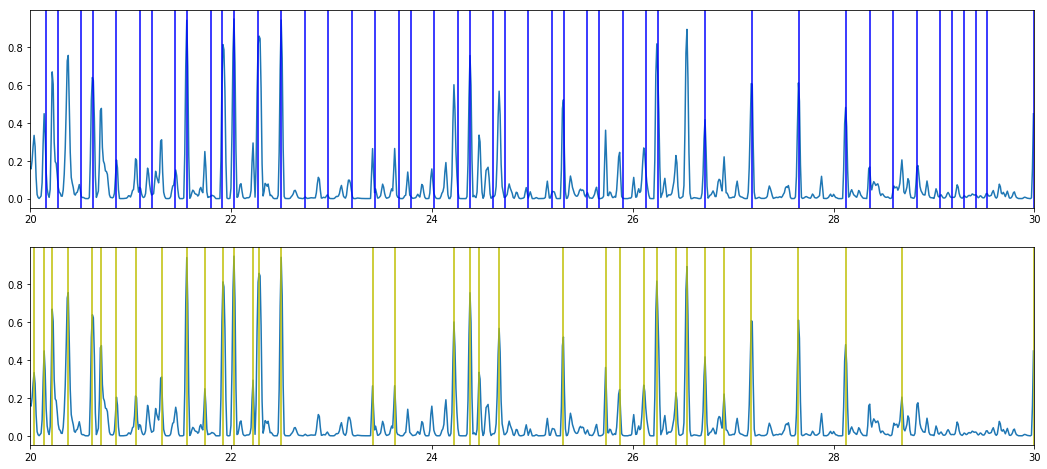

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(18, 8)
start = 20
end = 30
snip = pdf[start * 100: end*100]
x = np.arange(start*100, end*100) * 0.01

ax1 = plt.subplot(211)
ax1.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in lines:
    if mark < start:
        continue
    elif mark > end:
        break
    ax1.axvline(x=mark, color= 'b')
plt.xlim(start, end)
ax2 = plt.subplot(212)
ax2.plot(x, snip)
#plt.axhline(y=0.5, color='r', linestyle='-')
for mark in b_baseline*0.01:
    if mark < start:
        continue
    elif mark > end:
        break
    ax2.axvline(x=mark, color= 'y')
plt.xlim(start, end)
plt.show()